[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset Overview:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14  

Dataset Shape: (33716, 5)

Missing Values:
Message ID      0
Subject       289
Message       371
Spam/Ham        0
Date            0
dtype: int64

Class Distribution:
label
spam    17171
ham     16545
Name: count, dtype: int64


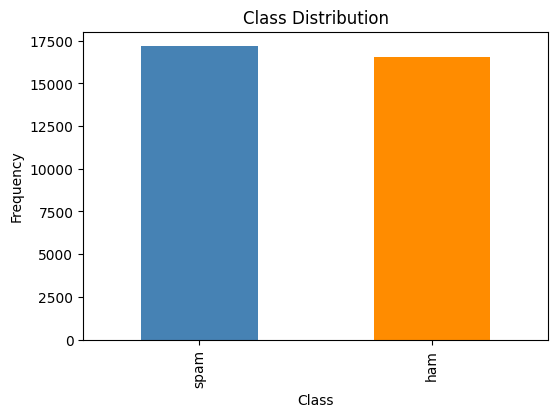


Pre-processing text ...

Sample pre-processed text:
['', 'gari product high island larger block commenc saturday p gross carlo expect gross tomorrow vastar own gross product georg x forward georg weissman hou ect daren j farmer carlo j rodriguez hou ect ect cc georg weissman hou ect ect melissa grave hou ect ect subject vastar resourc inc carlo pleas call linda get everyth set go estim come tomorrow increas follow day base convers bill fischer bmar forward daren j farmer hou ect enron north america corp georg weissman daren j farmer hou ect ect cc gari bryan hou ect ect melissa grave hou ect ect subject vastar resourc inc darren attach appear nomin vastar resourc inc high island larger block previous erron refer well vastar expect well commenc product sometim tomorrow told linda harri get telephon number ga control provid notif turn tomorrow linda number record voic fax would pleas see someon contact linda advis submit futur nomin via e mail fax voic thank georg x forward georg weissm

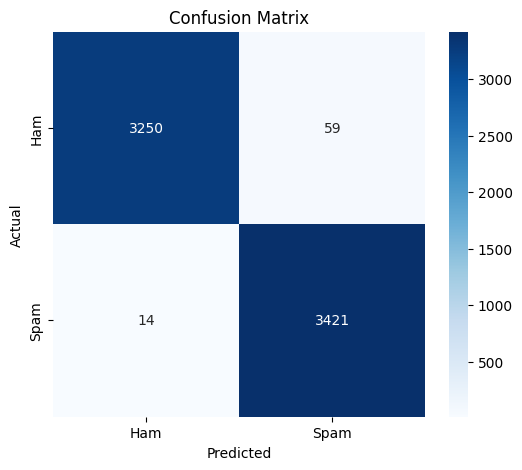


Model saved as 'ensemble_model.pkl'


In [ ]:
# ======================= Imports ============================================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

from sklearn.metrics import (confusion_matrix, accuracy_score,
                             classification_report, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             average_precision_score, matthews_corrcoef)

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# ======================= NLTK prerequisites ================================
nltk.download("stopwords")

# ======================= 1. Load data ======================================
data = pd.read_csv('/content/drive/MyDrive/enron_spam_data.csv')  # path to dataset

print("Dataset Overview:")
print(data.head())
print("\nDataset Shape:", data.shape)

# check for missing
print("\nMissing Values:")
print(data.isnull().sum())

# keep / rename relevant cols
data = data[['Spam/Ham', 'Message']]
data.columns = ['label', 'message']

# fill possible NaNs
data['message'] = data['message'].fillna('')

# ======================= 2. Class distribution =============================
print("\nClass Distribution:")
print(data['label'].value_counts())
plt.figure(figsize=(6, 4))
data['label'].value_counts().plot(kind='bar', color=['steelblue', 'darkorange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# ======================= 3. Text preprocessing =============================
print("\nPre-processing text ...")
ps = PorterStemmer()
eng_stop = set(stopwords.words('english'))

corpus = []
for msg in data['message']:
    review = re.sub('[^a-zA-Z]', ' ', msg)
    review = review.lower().split()
    review = [ps.stem(w) for w in review if w not in eng_stop]
    corpus.append(' '.join(review))

print("\nSample pre-processed text:")
print(corpus[:3])

# ======================= 4. Dual-channel TF-IDF ============================
word_vect = TfidfVectorizer(analyzer='word',
                            ngram_range=(1, 2),
                            max_features=8000,
                            min_df=3,
                            sublinear_tf=True)

char_vect = TfidfVectorizer(analyzer='char',
                            ngram_range=(3, 5),
                            max_features=30000,
                            sublinear_tf=True)

X_word = word_vect.fit_transform(corpus)
X_char = char_vect.fit_transform(corpus)
X = hstack([X_word, X_char])

y = pd.get_dummies(data['label'], drop_first=True).values.ravel()

# ======================= 5. Train / test split =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training shape :", X_train.shape)
print("Testing shape  :", X_test.shape)

# ======================= 6. Build models ===================================
svc = CalibratedClassifierCV(LinearSVC(), method='sigmoid', cv=5)
nb  = ComplementNB()
gb  = GradientBoostingClassifier()

ensemble_model = VotingClassifier(
    estimators=[('svc', svc), ('nb', nb), ('gb', gb)],
    voting='soft',
    weights=[2, 1, 2]
)

# ======================= 7. Train ==========================================
print("\nTraining ensemble ...")
ensemble_model.fit(X_train, y_train)

# ======================= 8. Evaluate =======================================
pred = ensemble_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, pred)
accuracy   = accuracy_score(y_test, pred)
precision  = precision_score(y_test, pred, average='weighted')
recall     = recall_score(y_test, pred, average='weighted')
f1         = f1_score(y_test, pred, average='weighted')
mcc        = matthews_corrcoef(y_test, pred)
roc_auc    = roc_auc_score(y_test, pred)
auprc      = average_precision_score(y_test, pred)

print("\n=== Metrics ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)
print("Matthews :", mcc)
print("ROC-AUC  :", roc_auc)
print("AUPRC    :", auprc)

print("\nClassification Report:")
print(classification_report(y_test, pred, target_names=['Ham', 'Spam']))

# Confusion-matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ======================= 9. Persist model ==================================
with open("ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble_model, f)

print("\nModel saved as 'ensemble_model.pkl'")
